# Phase Dispersion Space Estimation

## post-type meta-atom

```
radius  _______________ z3 = z2 + Δz3  (output)
  r3         _|3|______ z2 = z1 + Δz2
  r2       _|  2  |____ z1 = z0 + Δz1
  r1    __|____1____|__ z0 = 0.0       (input, phase is zero for all wavelengths)
           ~~~~~~~~~
          (eigenmode)
```

Phase accumulated in a post-type meta-atom can be expressed as:

$$
\phi^{\textrm{MA}}(\lambda, r_1, r_2, r_3) = \sum_i k_i(r_i) \Delta z_i = \sum_i \frac{2 \pi n_i^\textrm{eff}(r_i)}{\lambda} \Delta z_i
$$

where $\lambda$ - radiation wavelength in vacuum, $\Delta z_i$ - thickness of the $i$-th layer, $H = \sum_i \Delta z_i$ - total height, $n_i^\textrm{eff}$ - effective index of the $i$-th layer.

For a defined wavelength range $[\lambda_{\min},\lambda_{\max}]$, phase dispersion can be calculated as:

$$
\Delta\phi^{\textrm{MA}} = \phi_{\max}^{\textrm{MA}} - \phi_{\min}^{\textrm{MA}}.
$$

By substituting all possible values of the radii we can find the spacein this equation, phase dispersion space can be found.

## imports & basic functions

In [1]:
import itertools
from pathlib import Path
import numpy as np
import meep as mp
from meep import mpb
from matplotlib import pyplot as plt

mp.verbosity(0);  # switchs of log output

Using MPI version 4.0, 1 processes


In [2]:
##### wavelength range
wl_min = 8     # min. wavelength [μm]
wl_max = 12    # max. wavelength [μm]

##### meta-atom parameters
H = 48         # total height of meta-atom    [μm]
dr = 7         # meta-atom's pitch            [μm]
n_Si = 3.418   # refractive index of Si; https://refractiveindex.info/?shelf=main&book=Si&page=Chandler-Horowitz
r_min = 0.5    # min. possible radius of cyl. post [μm]
r_max = 3.0    # max. possible radius of cyl. post [μm]
Nr = 101       # number of intermediate points in [r_min;r_max] range
r_range = np.linspace(r_min, r_max, Nr)

##### MEEP (MPB) parameters
res = 25       # resolution [points/μm]; higher is better
parity = mp.NO_PARITY

#### data saving
save_dir = Path('output')
fig_dpi = 200  # default resolution for matplotib figures [dpi]

## basic functions

In [3]:
def draw_progress_bar(progress: float,
                      bar_len: int = 20) -> None:
    '''
    Draws simple updatable progress bar based on the input value in the range of [0,1].
    '''
    assert  0 <= progress <= 1, 'Incorrect input value. Should be in the range of [0,1].'
    print('[{:<{}}] {:.2%}'.format('='*int(bar_len*progress), bar_len, progress), end='\r', flush=True)
    # if progress == 1: print('\n')

def find_k_cyl(wl, r_cyl, n_cyl=n_Si, dr=dr, res=res, parity=mp.NO_PARITY, return_k_only=True):
    '''
    Finds fundamental eigenmode of a cylinder depending on the input parameters:
    wavelength, radius, cyl. radius, cyl. index, meta-atoms pitch etc.
    '''
    freq = 1./wl  # frequency
    
    sy = sz = dr   # lattice width/height [μm]
    geometry_lattice = mp.Lattice(size=mp.Vector3(0,sy,sz))
    
    geometry = [
        mp.Cylinder(radius=r_cyl,
                    axis=mp.Vector3(x=1),
                    center=mp.Vector3(),
                    material=mp.Medium(index=n_cyl))
    ]
    
    # solver class initialization
    ms = mpb.ModeSolver(
        geometry_lattice = geometry_lattice,
        geometry         = geometry,
        resolution       = res,              # !!! resolution should be at least λ/10
        num_bands        = 1,                # !!! only first (fundamental) eigenmode to be found 
        default_material = mp.air,           # !!! air is default surrounding material
    ) 
    
    # effective index calculation       
    k = ms.find_k(
        p              = parity,             # eigenmode parity; if axial symmetry then TE: mp.ODD_Y + mp.EVEN_Z, TM: mp.EVEN_Y + mp.ODD_Z
        omega          = freq,
        band_min       = 1,
        band_max       = 1,
        korig_and_kdir = mp.Vector3(x=1),
        tol            = 1e-5,
        kmag_guess     = freq * n_cyl,
        kmag_min       = freq * 0.5,
        kmag_max       = freq * 4.0,
    )
    
    k = k[0] * (2*np.pi) # !!! MEEP's units conversion
    
    if return_k_only:
        return k
    else:
        eps = ms.get_epsilon()
        efield = ms.get_efield(which_band=1, bloch_phase=False)
        return eps, efield, k

def plot_efields(eps, efield, dr, res, parity):
    '''
    Plots cylinder and electric field components.
    '''
    x = y = np.linspace(-0.5*dr, 0.5*dr, int(dr*res))
    E_labels = '|Ex|', '|Ey|', '|Ez|'
    
    fig, axs = plt.subplots(1,3,figsize=(7,2))
    fig.suptitle(f'res = {1/res:.3f} μm, parity: "{parity}"')
    
    for i, (ax, l) in enumerate(zip(axs, E_labels)):
        
        ax.pcolormesh(x, y, eps.transpose(), cmap='binary', alpha=0.5)                        # cylinder
        c =  ax.pcolormesh(x, y, np.abs(efield[:,:,0,i].transpose()), cmap='RdBu', alpha=0.7) # electric field amp.
        fig.colorbar(c, ax=ax)
        ax.set_title(l)
        ax.set_xlabel('Y [μm]')
        ax.set_ylabel('Z [μm]')
        ax.set_aspect('equal')
    
    fig.tight_layout()

def plot_n_eff(k_min_cyl, k_max_cyl):
    '''
    Plots effective indices for cylindrical waveguides depending on radius.
    '''
    fig, axs = plt.subplots(1,2,figsize=(8,3))
    fig.suptitle(f'wavelength wange: {wl_min}-{wl_max} μm')

    axs[0].plot(r_range, k_min_cyl / (2*np.pi) * wl_max, 's-', label='$n_{min}^{eff}$', 
                fillstyle='none', markersize=5, markeredgewidth=0.5)
    axs[0].plot(r_range, k_max_cyl / (2*np.pi) * wl_min, 'o-', label='$n_{max}^{eff}$',
                fillstyle='none', markersize=5, markeredgewidth=0.5)
    axs[0].axhline(y=1.00, c='gray', linestyle='--', label='Air')
    axs[0].axhline(y=n_Si, c='gray', linestyle='-.', label='Si')
    axs[0].set_xlim([r_range[0], r_range[-1]])
    axs[0].set_xlabel('radius of cylinder [μm]')
    axs[0].set_ylabel('$n_{eff}$')
    axs[0].legend(bbox_to_anchor=[1.,0.35], loc='center right', fontsize='small')

    axs[1].plot(r_range, k_max_cyl-k_min_cyl, 's-', label='$n_{min}^{eff}$',
                fillstyle='none', markersize=5, markeredgewidth=0.5)
    axs[1].set_xlim([r_range[0], r_range[-1]])
    axs[1].set_ylabel('$\Delta k$')
    axs[1].set_xlabel('radius of cylinder [μm]')

    fig.tight_layout()
    
def plot_phase_disp_space(phi0_H,  delta_phi0_H,
                          phi0_3h, delta_phi0_3h,
                          q_low=0.01, q_up=0.99,
                          alpha=0.1,
                          save_plot=False):
    '''
    Plots phase dispersion space for cylindrical meta-atoms with total height H.
    '''
    fig, axs = plt.subplots(1,2,figsize=(10,3))
    fig.suptitle(f'phase dispersion space, H = {H} μm')

    axs[0].plot(phi0_3h / (2*np.pi), delta_phi0_3h / (2*np.pi), '.',
                label='three cyl.', markersize=1, alpha=alpha)
    axs[0].plot(phi0_H  / (2*np.pi), delta_phi0_H  / (2*np.pi), 'o',
                label='single cyl.', markersize=4, fillstyle='none')
    axs[0].set_title('unwrapped')
    axs[0].set_xlabel('$\phi_0~/~2\pi$ [rad]')
    axs[0].set_ylabel('$\Delta\phi~/~2\pi$ [rad]')
    # axs[0].legend(loc='lower right')

    axs[1].plot(np.angle(np.exp(1j*phi0_3h)) / (2*np.pi), delta_phi0_3h / (2*np.pi), '.',
                label='three cyl.', markersize=1, alpha=alpha)
    axs[1].plot(np.angle(np.exp(1j*phi0_H))  / (2*np.pi), delta_phi0_H  / (2*np.pi), 'o',
                label='single cyl.', markersize=4, fillstyle='none')
    # 0.05 and 0.95 quantiles
    quant_lower = np.quantile(delta_phi0_3h,q_low) / (2*np.pi)
    quant_upper = np.quantile(delta_phi0_3h,q_up)  / (2*np.pi)
    print(f'Lower quantile: {quant_lower:.3f} × 2π',
          f'Upper quantile: {quant_upper:.3f} × 2π',
          f'Δ = {quant_upper-quant_lower:.2f} × 2π',
          sep='\n')
    axs[1].axhline(quant_lower, label='0.01 quant.', c='k', ls='--')
    axs[1].axhline(quant_upper, label='0.99 quant.', c='k', ls='-.')
    
    axs[1].set_title('wrapped')
    axs[1].set_xlabel('$\phi_0~/~2\pi$ [rad]')
    axs[1].set_ylabel('$\Delta\phi~/~2\pi$ [rad]')
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.tight_layout()
    
    if save_plot:
        fig.savefig(save_dir.joinpath(f'phase_disp_space_H={H}um.png'), dpi=fig_dpi)
    

## test run

n_eff = 3.11345 for λ = 10.00 μm, r_cyl = 2.50 μm, and parity = "no parity"
n_eff = 3.11345 for λ = 10.00 μm, r_cyl = 2.50 μm, and parity = "TE mode (S-)"
n_eff = 3.11344 for λ = 10.00 μm, r_cyl = 2.50 μm, and parity = "TM mode (P-)"


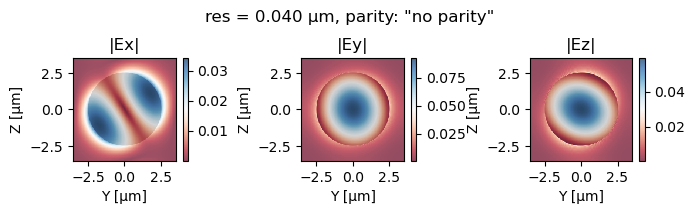

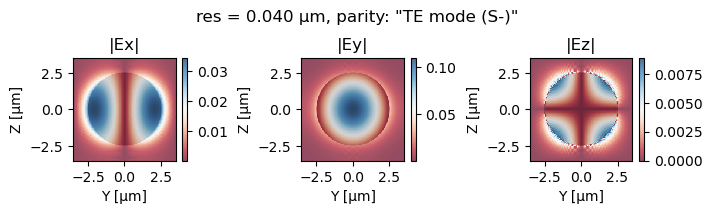

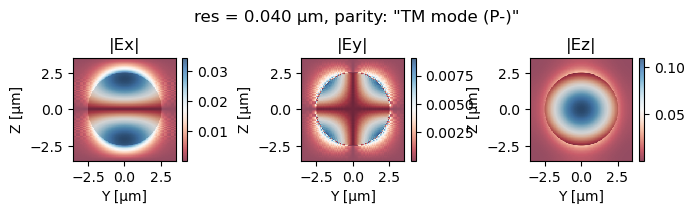

In [4]:
# test params
wl_test = 10
r_cyl_test = 2.5
res_test = 25

parity = {
    'no parity':    mp.NO_PARITY,
    'TE mode (S-)': mp.ODD_Y  + mp.EVEN_Z,
    'TM mode (P-)': mp.EVEN_Y + mp.ODD_Z
}

for pk, pv in parity.items():
    eps, efield, k = find_k_cyl(wl_test, r_cyl_test,  res=res_test, parity=pv, return_k_only=False)
    n_eff = k / (2*np.pi) * wl_test
    plot_efields(eps, efield, dr, res_test, pk)
    print(f'n_eff = {n_eff:.5f} for λ = {wl_test:.2f} μm, r_cyl = {r_cyl_test:.2f} μm, and parity = "{pk}"')

## main run

In [5]:
k_min_cyl = np.zeros(Nr)
k_max_cyl = np.zeros(Nr)

for i, r in enumerate(r_range):
    k_max_cyl[i] = find_k_cyl(wl=wl_min, r_cyl=r)
    k_min_cyl[i] = find_k_cyl(wl=wl_max, r_cyl=r)
    draw_progress_bar((i+1)/Nr)

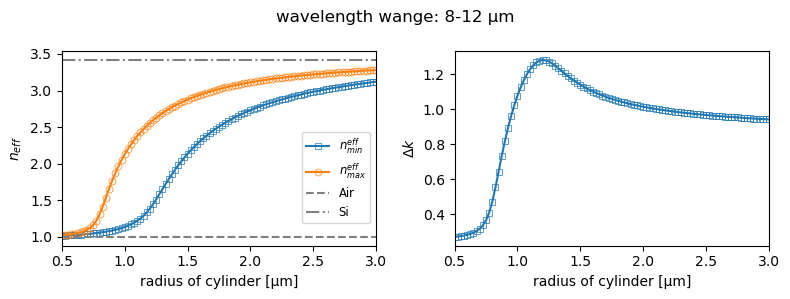

In [6]:
plot_n_eff(k_min_cyl, k_max_cyl)

## phase dispersion space

In [7]:
##### single cylinder (H)
phi0_H = k_min_cyl * H
delta_phi0_H = (k_max_cyl - k_min_cyl) * H

##### three stacked cylinders (H = 3*h)
h = H/3
ijk = list( itertools.combinations(range(Nr),3) ) # all unique combinations if indices
Nijk = len(ijk)

phi0_3h = np.zeros(Nijk)
delta_phi0_3h = np.zeros(Nijk)
for num, (i,j,k) in enumerate(ijk):
    phi_min = (k_min_cyl[i]+k_min_cyl[j]+k_min_cyl[k]) * h
    phi_max = (k_max_cyl[i]+k_max_cyl[j]+k_max_cyl[k]) * h
    phi0_3h[num] = phi_min
    delta_phi0_3h[num] = phi_max - phi_min

In [8]:
plot_phase_disp_space(phi0_H, delta_phi0_H, phi0_3h, delta_phi0_3h,
                      q_low=0.01, q_up=0.999,
                      alpha=0.2, save_plot=True)

Lower quantile: 3.966 × 2π
Upper quantile: 9.526 × 2π
Δ = 5.56 × 2π
